In [1]:
from qiskit import *
from qiskit.visualization import plot_histogram, plot_bloch_vector, plot_bloch_multivector, plot_state_qsphere
from math import sqrt, pi, acos, floor, log2, ceil, gcd
import numpy as np
from numpy.random import randint
import matplotlib.pyplot as plt
from random import randint
from fractions import Fraction
from qiskit.providers.ibmq import least_busy
import time

In [2]:
def sSim(circuit, shots = 256, draw=True):
#     simulator = Aer.get_backend('simulator_stabilizer')
    IBMQ.load_account()
    provider = IBMQ.get_provider(hub = 'ibm-q' , group = 'open' , project = 'main')
    simulator = provider.get_backend('simulator_mps')
    job = execute(circuit, simulator, shots = shots)
    result = job.result()
    counts = result.get_counts()
    if draw:
        print(counts)
        display(plot_histogram(counts))
    return counts

def rSim(circuit, shots = 256, draw=True):
    IBMQ.load_account()
    provider = IBMQ.get_provider(hub = 'ibm-q' , group = 'open' , project = 'main')
    qcomp = provider.get_backend('ibmq_manila')
    job = execute(circuit , backend = qcomp , shots = shots)
    job_monitor(job)
    result = job.result()
    counts = result.get_counts(circuit)
    
#     # Load local account information
#     IBMQ.load_account()
#     # Get the least busy backend
#     provider = IBMQ.get_provider(hub='ibm-q')
#     backend = least_busy(provider.backends(filters=lambda x:
#     x.configuration().n_qubits >= 2
#     and not x.configuration().simulator
#     and x.status().operational==True))
#     print("least busy backend: ", backend)
#     # Run our circuit
#     job = execute(circuit, backend=backend, shots=shots)
#     result = job.result()
#     counts = result.get_counts()
    if draw:
        print(counts)
        display(plot_histogram(counts))
    return counts

def stvq(circuit):
    simulator = Aer.get_backend('statevector_simulator')
    job = execute(circuit, simulator)
    result = job.result()
    statevector = result.get_statevector()
    print(statevector)
    display(plot_state_qsphere(statevector))

def stv(circuit):
    simulator = Aer.get_backend('statevector_simulator')
    job = execute(circuit, simulator)
    result = job.result()
    statevector = result.get_statevector(decimals=3)
    print(statevector)
    display(plot_bloch_multivector(statevector))
    
def b2d(counts,signed = True):
    max_key = max(counts, key=lambda key: counts[key])
    num = int(max_key,2)
    n = len(max_key)
    if max_key[0] == '1' and signed:
        return num - 2**n
    else: return num

In [3]:
def initnum(a,n):
    U = QuantumCircuit(n)
    bitArr = []
    q = a
    for i in range(n):
        if q%2==1: U.x(i)
        q = q//2
    U = U.to_gate()
    U.name = "Init(%i)" % a
    return U

def ADD(a,n,ctrl=0,draw=False):
    U = QuantumCircuit(n)
    bitArr = []
    q = a
    for i in range(n):
        bitArr.append(q%2)
        q = q//2
    bBitArr = [0]*n
    for bi in range(n):
        for ai in range(bi+1):
            k = (bi+1-ai)
            if bitArr[ai]==1: bBitArr[bi] += 2**(-k)
    for bi in range(n):
        U.rz(2*pi*bBitArr[bi],n-1-bi)
    if draw: display(U.draw(output='mpl'))
    U = U.to_gate()
    U.name = "ADD(%i)" % a
    if ctrl==0:
        return U
    else:
        return U.control(ctrl)
    

def ADD_dagger(a,n,ctrl=0, draw=False):
    U = QuantumCircuit(n)
    bitArr = []
    q = a
    for i in range(n):
        bitArr.append(q%2)
        q = q//2
    bBitArr = [0]*n
    for bi in range(n):
        for ai in range(bi+1):
            k = (bi+1-ai)
            if bitArr[ai]==1: bBitArr[bi] += 2**(-k)
    for bi in range(n):
        U.rz(-2*pi*bBitArr[bi],n-1-bi)
    if draw: display(U.draw(output='mpl'))
    U = U.to_gate()
    U.name = "ADD_D(%i)" % a
    if ctrl==0:
        return U
    else:
        return U.control(ctrl)

# QFT
def qft(n):
    """n-qubit QFT the first n qubits in circuit"""
    qc = QuantumCircuit(n)
    # Don't forget the Swaps!
    for qubit in range(n//2):
        qc.swap(qubit, n-qubit-1)
    for j in range(n):
        for m in range(j):
            qc.cu1(np.pi/float(2**(j-m)), m, j)
        qc.h(j)
    qc.name = "QFT"
    return qc.to_gate()

def qft_dagger(n):
    """n-qubit QFTdagger the first n qubits in circuit"""
    qc = QuantumCircuit(n)
    # Don't forget the Swaps!
    for qubit in range(n//2):
        qc.swap(qubit, n-qubit-1)
    for j in range(n):
        for m in range(j):
            qc.cu1(-np.pi/float(2**(j-m)), m, j)
        qc.h(j)
    qc.name = "QFTD"
    return qc.to_gate()

def add_mod(a,N,n, draw=False): #n=n+1
    U = QuantumCircuit(n+3)
    c1 = n
    c2 = n+1
    ctrl = n+2
    U.append( ADD(a,n,2), [c1,c2] + list(range(n)) )
    U.append( ADD_dagger(N,n), range(n) )
    U.append( qft_dagger(n), range(n) )
    U.cx( n-1, ctrl )
    U.append( qft(n), range(n) )
    U.append( ADD(N,n,1), [ctrl]+list(range(n)) )
    U.append( ADD_dagger(a,n,2), [c1,c2] + list(range(n)) )
    U.append( qft_dagger(n), range(n) )
    U.x(n-1)
    U.cx( n-1, ctrl )
    U.x(n-1)
    U.append( qft(n), range(n) )
    U.append( ADD(a,n,2), [c1,c2] + list(range(n)) )
    if draw: display(U.draw(output='mpl'))
    U = U.to_gate()
    U.name = "ADD(%i)mod(%i)" % (a,N)
    return U

def add_mod_dagger(a,N,n, draw=False): #n=n+1
    U = QuantumCircuit(n+3)
    c1 = n
    c2 = n+1
    ctrl = n+2
    U.append( ADD_dagger(a,n,2), [c1,c2] + list(range(n)) )
    U.append( qft_dagger(n), range(n) )
    U.x(n-1)
    U.cx( n-1, ctrl )
    U.x(n-1)
    U.append( qft(n), range(n) )
    U.append( ADD(a,n,2), [c1,c2] + list(range(n)) )
    U.append( ADD_dagger(N,n,1), [ctrl]+list(range(n)) )
    U.append( qft_dagger(n), range(n) )
    U.cx( n-1, ctrl )
    U.append( qft(n), range(n) )
    U.append( ADD(N,n), range(n) )
    U.append( ADD_dagger(a,n,2), [c1,c2] + list(range(n)) )
    
    if draw: display(U.draw(output='mpl'))
    U = U.to_gate()
    U.name = "ADD(%i)mod(%i)\'" % (a,N)
    return U

def cmult_mod(a,N,n, draw=False):
    U = QuantumCircuit(2*n+3)
    ctrl = 0
    x = range(1,n+1)
    b = range(n+1,2*n+2)
    additional_bit = 2*n+2
    U.append( qft(n+1), b )
    for i in range(n):
        sub_a = (a*2**i)%N
        U.append( add_mod(sub_a,N,n+1), list(b)+[ctrl, x[i], additional_bit] )
    U.append( qft_dagger(n+1), b )
    if draw: display(U.draw(output='mpl'))
    U = U.to_gate()
    U.name = "cmult(%i)mod(%i)" % (a,N)
    return U

def cmult_mod_dagger(a,N,n, draw=False):
    U = QuantumCircuit(2*n+3)
    ctrl = 0
    x = range(1,n+1)
    b = range(n+1,2*n+2)
    additional_bit = 2*n+2
    U.append( qft(n+1), b )
    for i_v in range(n):
        i = n-1-i_v
        sub_a = (a*2**i)%N
        U.append( add_mod_dagger(sub_a,N,n+1), list(b)+[ctrl, x[i], additional_bit] )
    U.append( qft_dagger(n+1), b )
    if draw: display(U.draw(output='mpl'))
    U = U.to_gate()
    U.name = "cmult(%i)mod(%i)\'" % (a,N)
    return U

def U_a(a,N,n,draw=False,power=1):
    U = QuantumCircuit(2*n+3)
    if (gcd(a,N)!=1): raise Exception('a and N should be coprime')
    a_true = a**power
    U.append( cmult_mod(a_true,N,n), range(2*n+3) )
    for i in range(n):
        U.cswap(0,i+1,i+1+n)
    a_inv = 0
    a_inv = modinv(a_true , N)
#     for i in range(N):
#         if (a_true*i)%N==1: a_inv=i
    print(a_inv)
    U.append( cmult_mod_dagger(a_inv,N,n), range(2*n+3) )
    if draw: display(U.draw(output='mpl'))
    U = U.to_gate()
    U.name = " %i^%i mod(%i)" % (a,power,N)
    return U

## -----finding modular inverse-----
def egcd(a , b):
    if a == 0:
        return (b , 0 , 1)
    else:
        g , y , x = egcd(b % a , a)
        return (g , x - (b // a) * y , y)
def modinv(k , n):
    g , x , y = egcd(k , n)
    return x % n
## -----finding modular inverse-----

def shor(a,N,n,draw=False):
    m = ceil(log2(N**2))
    U = QuantumCircuit(m+2*n+2,2*n)
    
    ### build main func
    p1 = range(m)
    p2 = range(m,m+n)
    p3 = range(m+n,m+2*n)
    for i in p1:
        U.h(i)
    U.append(initnum(1,n),p2)
    U.append(initnum(0,n),p3)
    for i in p1:
        U.append( U_a(a,N,n,power=2**i), [i]+list(range(m,m+2*n+2)) )
    U.append(qft_dagger(len(p1)),p1)
    U.measure(p1,p1)
    if draw: display(U.draw(output='mpl'))
#     return sSim(U,shots=2**m)
    return sSim(U)
    # return stv(U)

def findP(N):
    if N%2==0: return 2
    count = 0
    while count<100:
        count+=1
        print('test #%i'%count)
        a = randint(2 , N - 1)
        if gcd(a,N)>1:
            print('find by gcd')
            return gcd(a,N)
        print('guess a=%i'%a)
        n = ceil(log2(N))
        counts = shor(a,N,n,True)
        rows, measured_phases = [], []
        for output in counts:
#             if counts[output]>7: #only choose high prob
#                 decimal = int(output, 2) # Convert (base 2) string to decimal
#                 phase = decimal/(2**ceil(log2(N**2))) # Find corresponding eigenvalue
#                 measured_phases.append(phase)
            decimal = int(output, 2) # Convert (base 2) string to decimal
            phase = decimal/(2**ceil(log2(N**2))) # Find corresponding eigenvalue
            measured_phases.append(phase)
        for phase in measured_phases:
            frac = Fraction(phase).limit_denominator(N)
            d = frac.denominator
            if(d%2==0):
                g1 = a**(d//2)-1
                g2 = a**(d//2)+1
                if g2%N!=0:
                    gcd1 = gcd(g1,N)
                    gcd2 = gcd(g2,N)
                    if gcd1>1 or gcd2>1:
                        print('period =',d)
                        gc = max(gcd1,gcd2)
                        print('%i = %i*%i'%(N,gc,N//gc))
                        return gc
        print('a!=%i'%a)


test #1
guess a=22


C:\Users\user\AppData\Local\Temp/ipykernel_17728/3937409033.py:66: DeprecationWarning: The QuantumCircuit.cu1 method is deprecated as of 0.16.0. It will be removed no earlier than 3 months after the release date. You should use the QuantumCircuit.cp method instead, which acts identically.
  qc.cu1(np.pi/float(2**(j-m)), m, j)


8
29
1
1
1
1
1
1
1
1
1


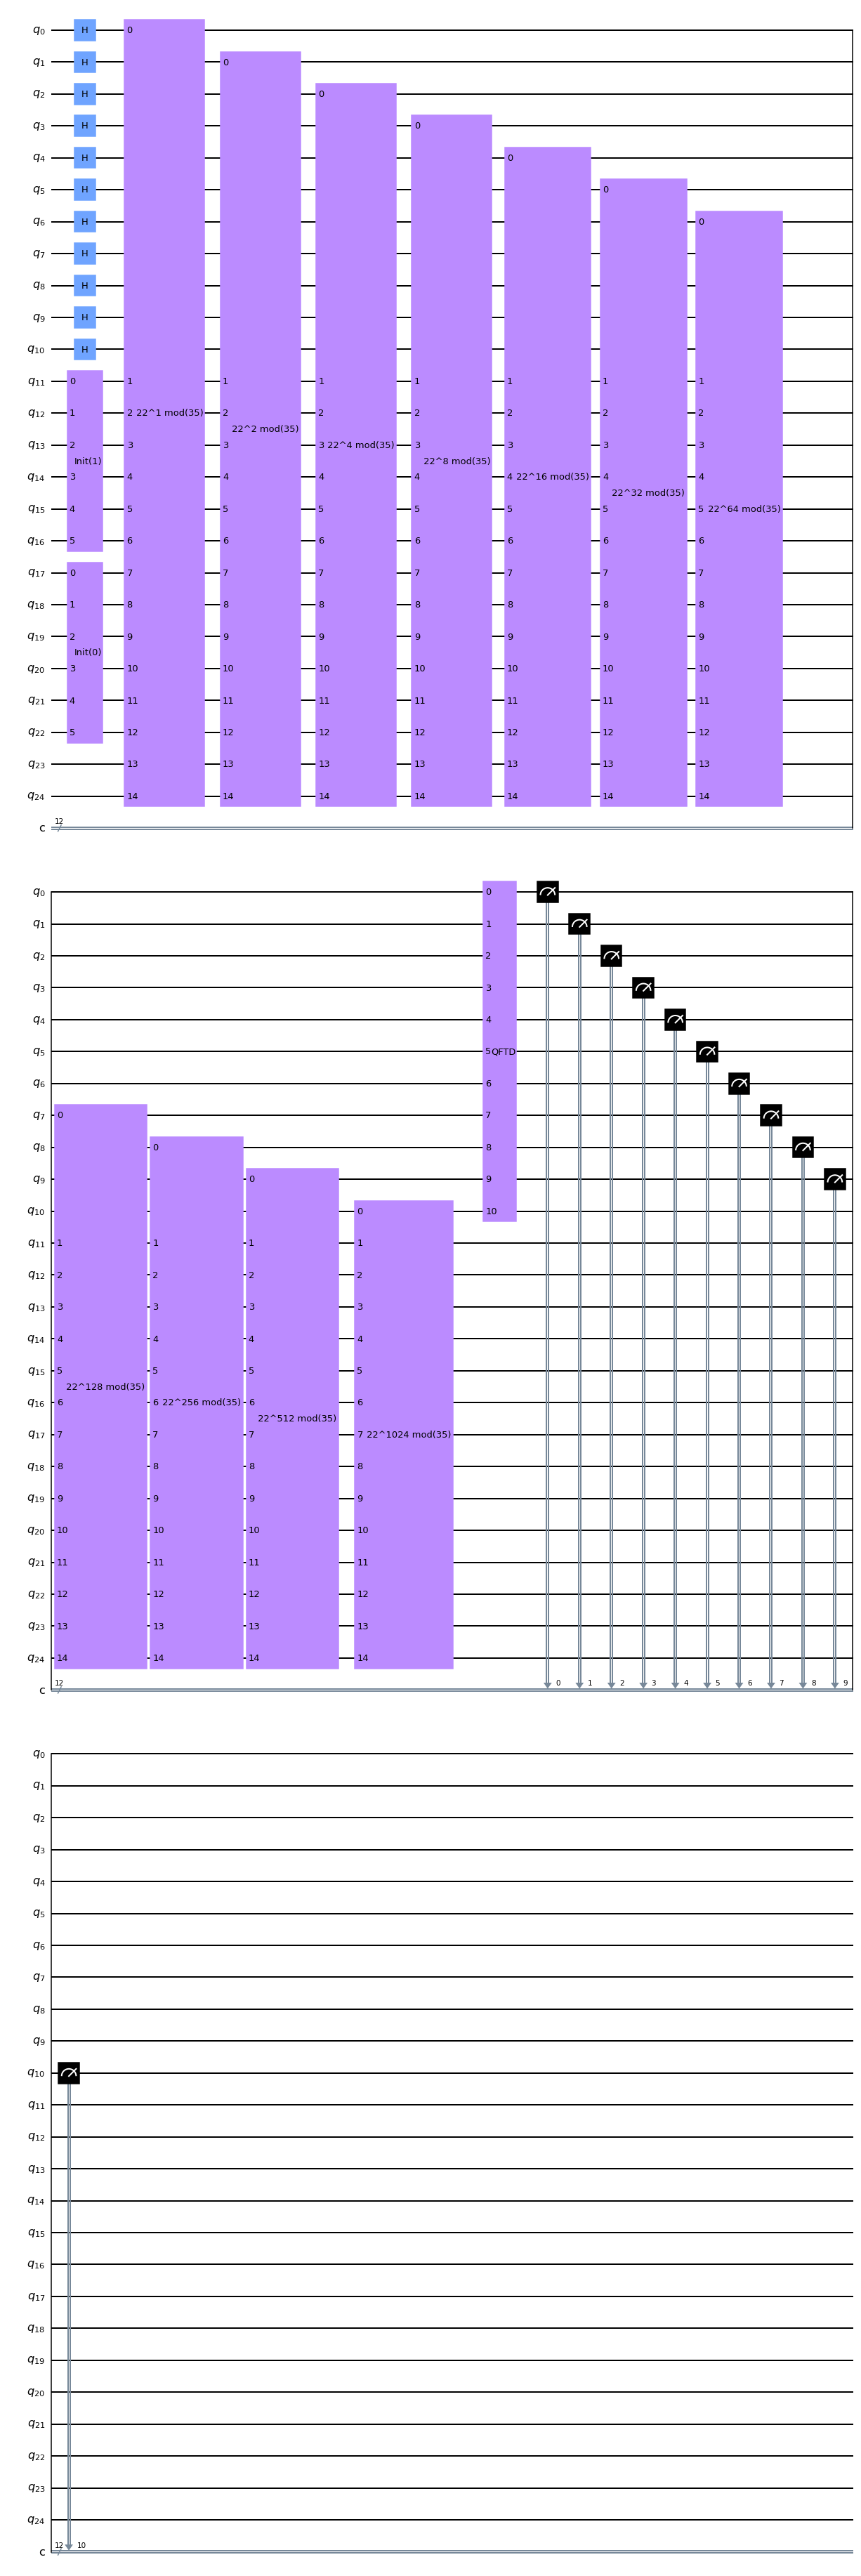

{'000000000000': 54, '001000000000': 68, '010000000000': 55, '011000000000': 79}


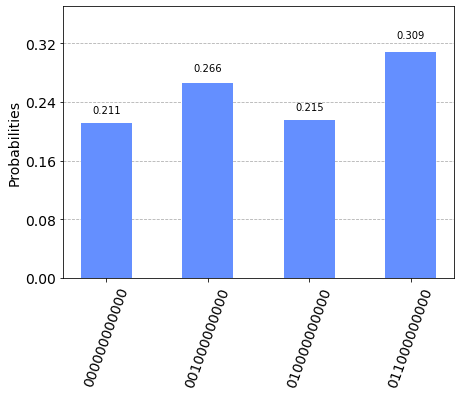

period = 4
35 = 7*5
time =  140.98180603981018


In [4]:
time_start = time.time()
findP(35)
time_end = time.time()
print("time = " , time_end - time_start)

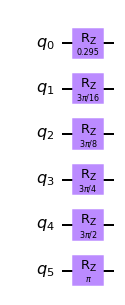

here


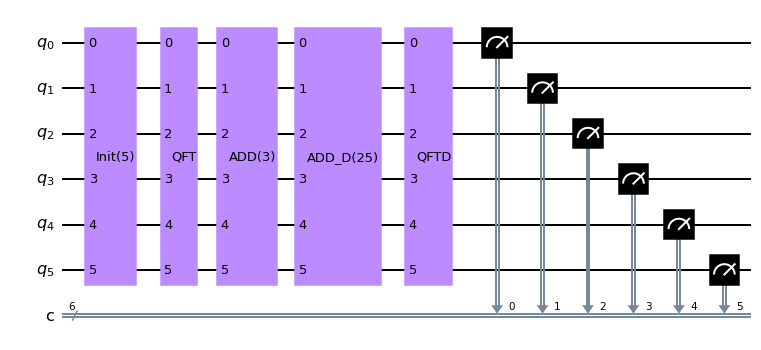

ibmqfactory.load_account:WARNING:2022-01-05 15:44:49,784: Credentials are already in use. The existing account in the session will be replaced.


{'101111': 256}


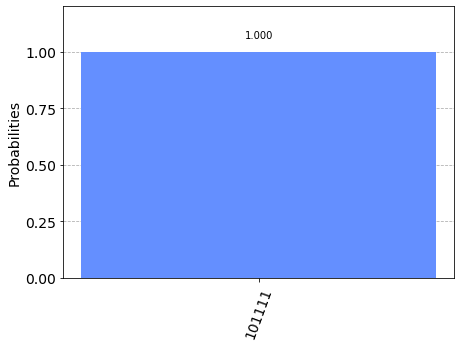

{'101111': 256}
5+3-25 = -17


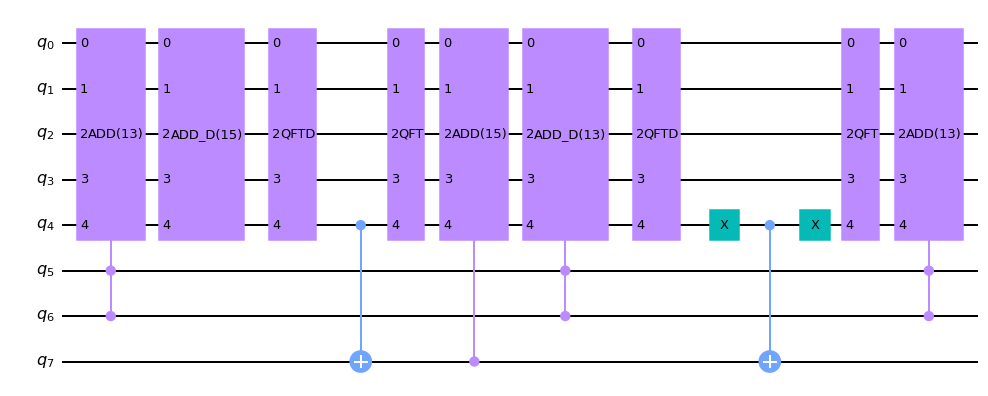

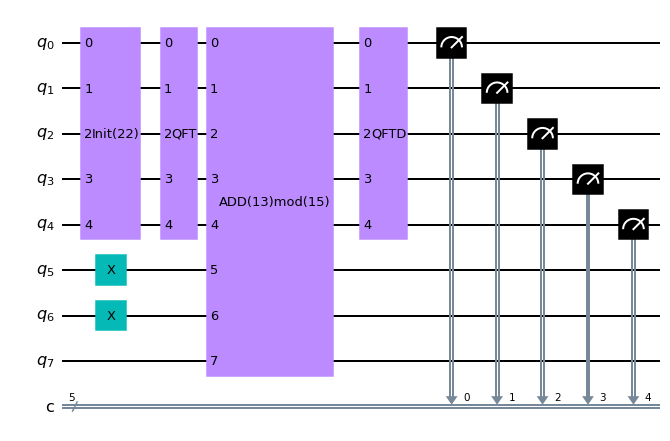

ibmqfactory.load_account:WARNING:2022-01-05 15:45:08,019: Credentials are already in use. The existing account in the session will be replaced.


{'00011': 256}


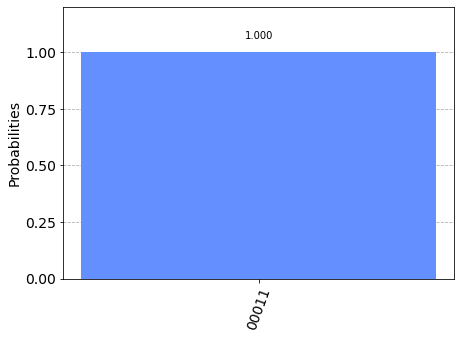

{'00011': 256}
22+13 mod(15) = 3


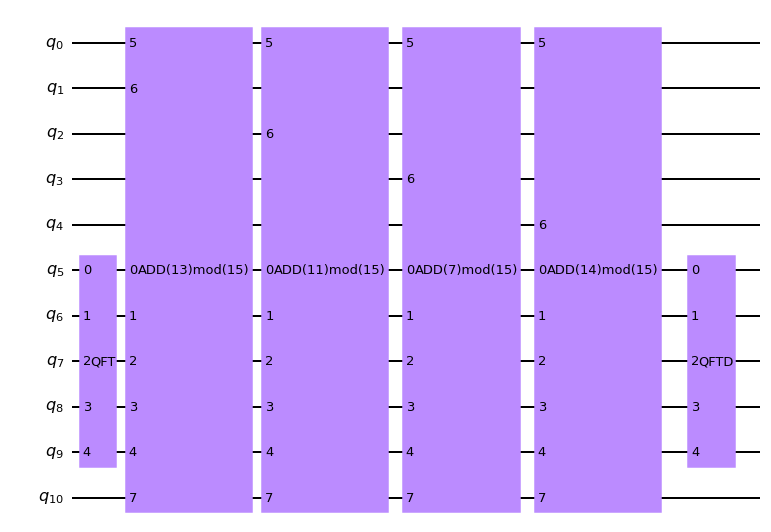

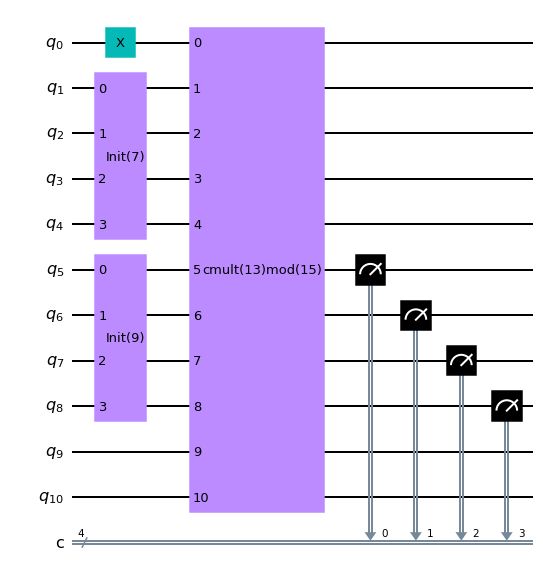

ibmqfactory.load_account:WARNING:2022-01-05 15:45:27,219: Credentials are already in use. The existing account in the session will be replaced.


{'1010': 256}


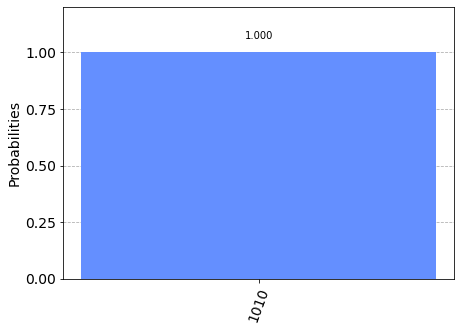

{'1010': 256}
9+13*7 mod(15) = 10
13


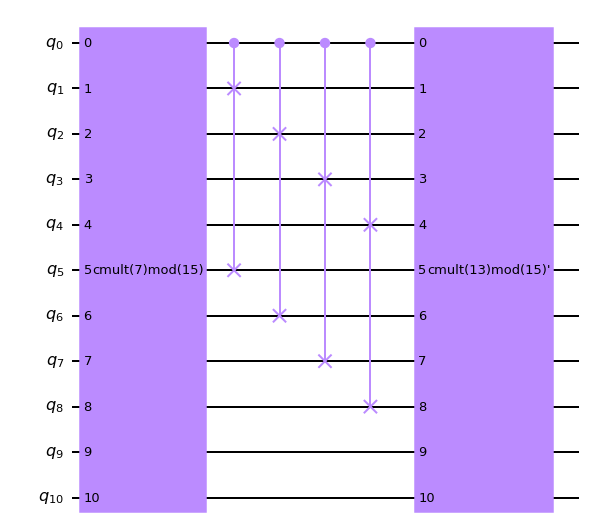

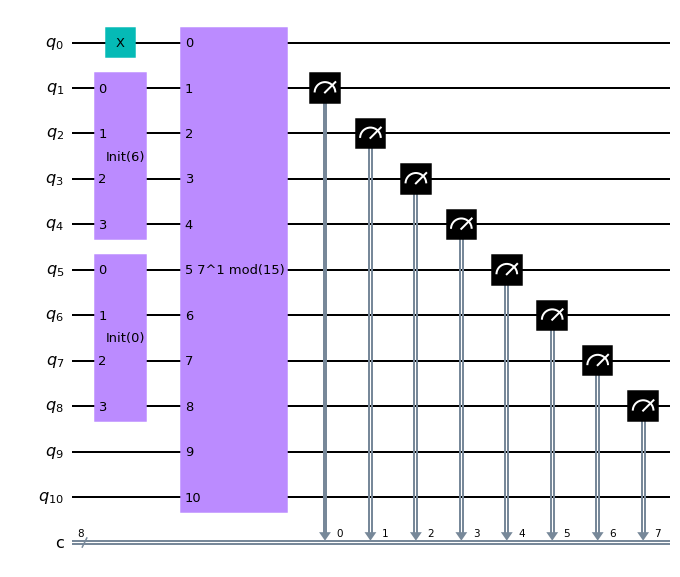

ibmqfactory.load_account:WARNING:2022-01-05 15:46:41,707: Credentials are already in use. The existing account in the session will be replaced.


{'00001100': 256}


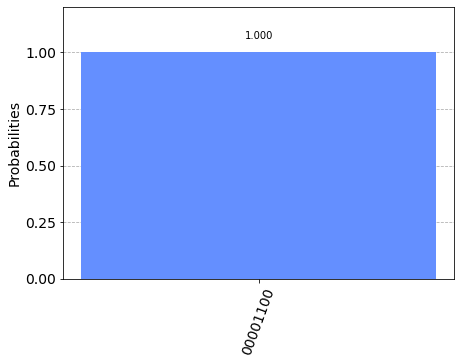

{'00001100': 256}
7*6 mod(15) = 12


In [5]:
###### test add: a+b-c ######
a, b, c = 3, 5, 25
n = ceil(log2(max(a,b,c)))+1
#### circuit ####
qc = QuantumCircuit(n,n)
qc.append(initnum(b,n),range(n))
qc.append(qft(n),range(n))
qc.append(ADD(a,n,draw=True),range(n))
qc.append(ADD_dagger(c,n),range(n))
qc.append(qft_dagger(n),range(n))
qc.measure(range(n),range(n))
print("here")
display(qc.draw(output='mpl'))
#### calculate ####
output = sSim(qc,draw=True)
print(output)
print('%i+%i-%i ='%(b,a,c),b2d(output))

###### test add_mod ######
a, b, N = 13, 22, 15
n = ceil(log2(max(a,b,N)))
#### circuit ####
qc = QuantumCircuit(n+3,n)
qc.append(initnum(b,n),range(n))
qc.x(n)
qc.x(n+1)
qc.append(qft(n),range(n))
qc.append(add_mod(a,N,n,draw=True),range(n+3))
qc.append(qft_dagger(n),range(n))
qc.measure(range(n),range(n))
display(qc.draw(output='mpl'))
#### calculate ####
output = sSim(qc,draw=True)
print(output)
print('%i+%i mod(%i) ='%(b,a,N),b2d(output))

##### test cmult_mod #####
a, b, x, N = 13, 9, 7, 15
n = ceil(log2(max(a,b,x,N)))
ctrl = 0
x_q = range(1,n+1)
b_q = range(n+1,2*n+1)
b_q_addition = range(n+1,2*n+2)
#### circuit ####
qc = QuantumCircuit(2*n+3,n)
### init ###
qc.x(ctrl)
qc.append(initnum(x,n),x_q)
qc.append(initnum(b,n),b_q)
### main ###
qc.append(cmult_mod(a,N,n,draw=True),range(2*n+3))
qc.measure(b_q,range(n))
display(qc.draw(output='mpl'))
#### calculate ####
output = sSim(qc,draw=True)
print(output)
print('%i+%i*%i mod(%i) ='%(b,a,x,N),b2d(output,signed=False))

##### test U_a #####
x, a, N = 6, 7, 15
n = ceil(log2(max(a,x,N)))
ctrl = 0
x_q = range(1,n+1)
b_q = range(n+1,2*n+1)
b_q_addition = range(n+1,2*n+2)
#### circuit ####
qc = QuantumCircuit(2*n+3,2*n)
### init ###
qc.x(ctrl)
qc.append(initnum(x,n),x_q)
qc.append(initnum(0,n),b_q)
### main ###
qc.append(U_a(a,N,n,draw=True),range(2*n+3))
qc.measure(range(1,2*n+1),range(n*2))
display(qc.draw(output='mpl'))
#### calculate ####
output = sSim(qc,draw=True)
print(output)
print('%i*%i mod(%i) ='%(a,x,N),b2d(output,signed=False))

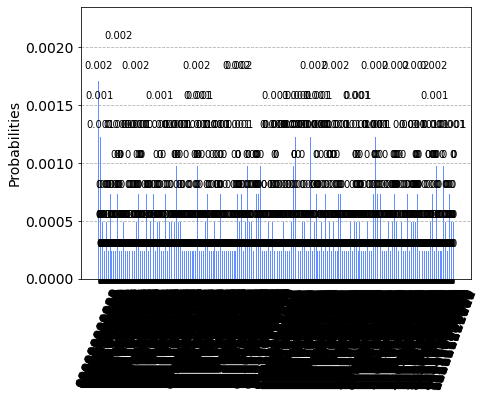

In [6]:
##### test shor part 1 #####
# a = 5
# N = 21
# n = ceil(log2(N))
# counts = shor(a,N,n,True)

##### history ####
# N, a = 21, 13
# counts = {'0000000000': 135, '0100000000': 121}
# N, a = 39, 11
# counts = {'011000000000': 17, '010001000110': 1, '000000010000': 1, '011101010101': 12, '010101010011': 1, '010100000100': 1, '010010101011': 7, '000000010110': 1, '010101010101': 10, '000101011001': 1, '010000000000': 16, '000010101001': 1, '000000000000': 18, '001010101001': 2, '001010000010': 1, '010010101100': 1, '000101010101': 17, '001010101011': 13, '010011111111': 1, '011010101010': 5, '011101010111': 1, '000101100000': 1, '011110110010': 1, '010101010000': 1, '011101010110': 7, '001000000000': 12, '001111111100': 2, '010010101010': 2, '001111101011': 1, '010000001000': 1, '010000100000': 1, '011111011110': 1, '001101010101': 11, '001010101010': 1, '011101011101': 1, '000101010110': 6, '010101010110': 4, '011110110101': 1, '010001000100': 1, '010000101011': 1, '001111111011': 1, '001000000001': 1, '000010101011': 9, '011100000000': 1, '000000100000': 1, '011010010101': 1, '011111110110': 1, '000010111100': 1, '010000101000': 1, '001101001001': 1, '001101101101': 1, '001010101101': 1, '000010101010': 3, '010001001101': 1, '010100100111': 1, '010010101101': 2, '010001011000': 1, '011110000000': 1, '011010101011': 10, '000010110011': 1, '000111111000': 1, '001101011001': 1, '010010110101': 1, '011011101011': 1, '001000100000': 1, '010010100101': 1, '000110001010': 1, '011101010100': 2, '010111111100': 1, '010101010100': 2, '010000000001': 1, '001100000000': 1, '010111110101': 1, '000001010101': 1, '001101010110': 1, '011110001000': 1, '001100101101': 1, '010001010111': 1, '000001101001': 1, '011000001000': 1, '011001000111': 1, '000001011101': 1, '011100001000': 1, '011101101101': 1, '010111010110': 1, '011011000000': 1, '000101010111': 1, '000010101100': 1, '000000000111': 1, '000101010100': 1}
# N, a = 57, 14
# counts = {'111011100100': 1, '011100001001': 1, '001110001110': 1, '110001110100': 1, '101000110010': 1, '111110100111': 1, '111010111001': 1, '001001111001': 1, '001110101111': 1, '111010111010': 1, '011111110111': 1, '010011011011': 1, '101011100011': 1, '010011111110': 1, '001110000100': 1, '011111000101': 1, '101010010101': 1, '010010010100': 1, '010110001011': 1, '000011000111': 1, '100000111001': 2, '110001011000': 1, '011101011001': 1, '100110001101': 1, '111100100001': 1, '011111001100': 1, '010100110101': 1, '101000111010': 1, '001110000111': 1, '001111110101': 1, '100110001000': 1, '100000110010': 1, '100101010100': 1, '111001000011': 1, '101001011010': 2, '010000000011': 1, '000101010001': 1, '011011110110': 1, '011110110111': 1, '101010101011': 1, '110100010011': 1, '110111011100': 1, '001001001110': 1, '110111111001': 1, '100101100010': 1, '100100001010': 1, '011111001011': 1, '111010101011': 1, '110000100001': 1, '010110011110': 1, '011001101100': 1, '100001011000': 1, '110100000101': 1, '110000010101': 1, '000100110001': 1, '011101010101': 1, '011100100111': 1, '010001011101': 1, '000100001011': 1, '011111010000': 1, '000000001100': 1, '100100100100': 1, '011001001010': 1, '011001111000': 1, '011010010001': 1, '110100111010': 1, '110011011100': 1, '010100111000': 2, '110001010111': 1, '011000111001': 1, '111010110001': 1, '000011110000': 1, '010000111001': 1, '110010011110': 1, '101010010011': 1, '110001010101': 1, '100000001110': 1, '111010011011': 1, '110101011110': 1, '010011111011': 1, '110110010111': 1, '100010111001': 1, '000001010101': 1, '001000110111': 1, '101010100010': 1, '101100100000': 1, '001000001001': 2, '100111101110': 1, '100111110000': 1, '001010010100': 1, '011001111001': 1, '111100000011': 1, '101000111111': 1, '101011101010': 1, '100101000111': 1, '011111111111': 1, '111011000011': 1, '001110101011': 1, '111100111110': 1, '101001001100': 1, '000101110001': 1, '111111101111': 1, '000111111010': 1, '010110011101': 1, '111001111100': 1, '111000010101': 1, '001011101000': 1, '000100101100': 1, '110100101100': 1, '110010111100': 1, '111100110000': 1, '101101101110': 1, '001111011000': 1, '011101111001': 1, '001110011111': 1, '011101001110': 1, '001011100011': 1, '010011110001': 1, '001111001000': 1, '101001110010': 3, '001000001000': 1, '000101110110': 1, '101101001101': 1, '001001001001': 1, '101101011110': 1, '010100100011': 1, '101000111001': 1, '001001000011': 1, '010100010001': 1, '000010101000': 1, '010000100111': 1, '010111100100': 1, '011110000101': 1, '101011100100': 2, '100100111100': 1, '110110011010': 1, '011011010101': 1, '101111010000': 1, '101101011001': 1, '001110110000': 1, '111001111110': 1, '111000010011': 1, '011010010100': 1, '001101010101': 2, '110011010011': 1, '010101000110': 1, '000011111100': 1, '000000000000': 1, '010100010101': 1, '101101101001': 1, '001000011101': 1, '001100110001': 1, '101111111010': 1, '110000111101': 1, '011110101011': 1, '000010000101': 1, '110001111100': 1, '010110010110': 1, '100111000001': 1, '001111000001': 1, '100111001110': 2, '101001110001': 1, '110010110011': 1, '100100111010': 1, '011101111101': 1, '001111011110': 1, '111011000111': 1, '101100111011': 1, '100100111110': 1, '100010011100': 1, '111011111000': 1, '101000111011': 1, '111101001000': 1, '010100011010': 1, '000101011001': 1, '011011110010': 1, '010101010111': 1, '000100011101': 1, '100010101010': 1, '100000000101': 1, '110010110000': 1, '110000101011': 1, '100101010011': 1, '101101010000': 1, '001010101011': 1, '000001010010': 1, '010110101010': 1, '010100100001': 1, '101011101011': 1, '100101110010': 1, '001101101110': 1, '100010111101': 1, '011011111111': 1, '000011001001': 1, '001000100111': 1, '111101001101': 1, '000000000101': 1, '110000101100': 1, '101111011101': 1, '111101001001': 1, '110100101110': 1, '100001000001': 1, '110111100100': 1, '110111101001': 1, '111011010111': 1, '010011110010': 1, '100110001110': 1, '110101001101': 1, '110111000001': 1, '010110001110': 1, '000111001001': 1, '111100101001': 1, '011011000100': 1, '110100101010': 1, '010111000111': 1, '000100000010': 1, '011011000111': 1, '011111100101': 1, '011010011000': 1, '001111111010': 1, '101001101111': 1, '000101111101': 1, '111100101011': 1, '100000001000': 1, '111000111001': 1, '111010010000': 1, '011010101010': 2, '111000010110': 1, '010000110001': 1, '010100000001': 1, '011010000101': 1, '010001011001': 1, '111100110010': 1, '101110100000': 1, '000010111010': 1, '011001001100': 1, '001111010011': 1, '101111000111': 1, '001000100010': 1, '000011010111': 1, '011010000010': 1, '101000011000': 1, '100010001100': 1, '110000101010': 1, '101101010100': 1, '100110000100': 1}
# N, a = 57, 44
# counts = {'100011010011': 1, '100000110110': 1, '100101011000': 1, '000111100000': 1, '000011001001': 1, '111111100000': 1, '111011011011': 1, '001001101001': 1, '100110001101': 1, '011101011001': 1, '011001010100': 1, '110100001001': 1, '011001101110': 1, '110100111000': 1, '101111111010': 1, '001011000011': 1, '101110000110': 1, '101000001110': 1, '101001110000': 1, '001111100111': 1, '110010010110': 1, '001011011101': 2, '100111110001': 1, '010101111011': 1, '111001101110': 1, '110111010010': 1, '011100000101': 1, '110110111101': 1, '000110001011': 1, '000111001100': 1, '010110011110': 1, '001100000011': 1, '000001110011': 1, '000101011101': 1, '101010000011': 1, '101101011111': 2, '010100100000': 1, '110010101001': 1, '111000111001': 2, '100010100101': 1, '111100111001': 1, '111000000111': 1, '100001101101': 1, '100110011010': 1, '000110001110': 1, '110010110011': 1, '101000101001': 1, '100000000110': 1, '100000011010': 1, '101111010000': 1, '101101010100': 1, '101000000000': 1, '110101010110': 1, '101001111110': 1, '111101010111': 1, '110011010001': 1, '011011011101': 1, '100011100101': 1, '101100000110': 1, '110100100011': 1, '111011110010': 1, '100001100010': 1, '010101110010': 1, '101110110010': 1, '010100011101': 1, '011000111001': 1, '111110110110': 1, '100011111101': 1, '111111111111': 1, '010100011000': 1, '001010110011': 1, '000100001000': 1, '110010100011': 1, '101011011110': 1, '011001011001': 1, '111100000100': 1, '101010001100': 1, '110110011010': 1, '100010000101': 1, '100001010000': 1, '101111001000': 1, '001101001010': 1, '011000110010': 1, '101110100000': 1, '000101001001': 1, '000000001101': 1, '111111011111': 1, '100011000111': 1, '110000011011': 1, '100111001011': 2, '000011001011': 1, '100100011000': 1, '110110101010': 1, '101001110001': 1, '001100001111': 1, '111110101000': 1, '100110101110': 2, '101001101011': 1, '000100001101': 1, '001110011010': 1, '110011011101': 1, '011100000100': 1, '010100001011': 1, '110111010000': 1, '101101010101': 1, '000011000111': 2, '111100011111': 1, '110100011001': 1, '001010101100': 2, '000110101010': 1, '100101010010': 1, '111110000010': 1, '000001111000': 1, '001001001100': 1, '011000000101': 1, '010100110111': 1, '011111001010': 1, '111101101000': 1, '001011100101': 1, '000101111110': 1, '011011000011': 1, '101001001110': 1, '101011011100': 1, '101010001110': 1, '111010011011': 1, '111101110011': 1, '111101001001': 1, '010001111110': 1, '111110110111': 1, '110001000000': 1, '110100100001': 1, '100111110100': 1, '001010010001': 1, '101110101001': 1, '110011110100': 1, '000000111000': 1, '111001100101': 1, '011111001000': 1, '010011000111': 1, '011011101100': 1, '100101001100': 1, '011010011001': 1, '101011001011': 1, '101111001110': 1, '111010110001': 1, '101111111011': 1, '101111011100': 1, '110011001100': 1, '010100011110': 1, '100011011101': 1, '110111001111': 1, '010010100010': 1, '100111001001': 1, '101001100101': 1, '110100000110': 1, '111110011001': 1, '101001000001': 1, '110111110110': 1, '111001100000': 1, '011101010110': 1, '001010001110': 1, '100010110111': 1, '101110100110': 1, '111100101110': 1, '011101010100': 1, '101101000000': 1, '000001011100': 1, '011100011111': 1, '001110110011': 1, '110110101110': 1, '110001010010': 1, '100100010011': 1, '111001111010': 1, '110011000111': 1, '110011100000': 1, '101010101100': 1, '011111000000': 1, '011101100110': 1, '010001101001': 1, '011010110011': 1, '110000101011': 1, '010000001010': 1, '111000111110': 1, '101001011000': 1, '011100100100': 1, '111110100000': 1, '011010110111': 1, '111011011010': 1, '100100011101': 1, '001111010101': 1, '001110001110': 1, '100101000011': 1, '110001000100': 1, '011010011110': 1, '001000000010': 1, '101111101101': 1, '011001101011': 1, '010001001011': 2, '100001111110': 1, '000000110111': 1, '001000011001': 1, '000110001001': 1, '111001010011': 1, '100111010110': 1, '111001001010': 1, '011110101100': 1, '001111101101': 1, '100111110111': 1, '101110101010': 1, '000011110100': 1, '010101101010': 1, '010111000001': 1, '011100011110': 1, '001101010001': 1, '111111001101': 1, '101000011110': 1, '101100111001': 1, '100000100001': 1, '000011010111': 1, '101010101011': 1, '100111111011': 1, '010110100101': 1, '101001001010': 1, '000010000100': 1, '110011011011': 1, '110110101100': 1, '101111000111': 1, '000111101101': 1, '011000010111': 1, '010100011001': 1, '000110101101': 2, '010000000111': 1, '110111001011': 1, '111100101100': 1, '111000011001': 1, '010110001110': 1, '111100001011': 1, '011010100011': 1, '000100111001': 1, '011111001011': 1, '110000011110': 1, '011011001100': 1, '010110110010': 1, '000011000101': 1, '011001010011': 1, '000111010101': 1, '010100101110': 1}
# N, a = 35, 33
# counts = {'010101010110': 8, '011110110101': 1, '010110011011': 1, '000001011001': 1, '010110101011': 1, '010010101011': 8, '010101001000': 1, '010101011000': 1, '001010000000': 1, '010010101010': 3, '011001010011': 1, '000010101100': 1, '001000000000': 22, '011011000000': 1, '010101001011': 2, '000101010101': 8, '001010101011': 9, '011101010101': 16, '001101010111': 1, '011110100111': 1, '011101101011': 1, '011100000000': 1, '000010101101': 1, '010110000000': 1, '000010101001': 1, '000000000000': 10, '011101111000': 1, '011000000000': 20, '011010101011': 8, '000011011001': 1, '010000000000': 15, '001101011001': 1, '011100110011': 1, '001010101101': 1, '000101010011': 1, '011101010110': 4, '010101001100': 1, '000111111010': 1, '011010101010': 3, '011101000100': 1, '010111010101': 1, '010101100000': 1, '011010011011': 1, '000101010111': 1, '010000000101': 1, '001010011011': 1, '010101011001': 1, '000010100011': 1, '011111000011': 1, '011010101101': 1, '000010101011': 7, '011000000101': 1, '000101010110': 4, '001010101010': 4, '010101010101': 16, '011010101000': 2, '001101010101': 5, '000111101110': 1, '000010101010': 4, '000110101011': 1, '000011001011': 2, '010010111100': 1, '001110101011': 1, '000011011110': 1, '011010111010': 1, '001010101100': 1, '010010000000': 1, '000010101000': 1, '001111010101': 1, '010101010111': 1, '010101001101': 1, '011101100100': 1, '000110010100': 1, '001110101010': 1, '001001010101': 1, '010010011011': 1, '000001011011': 1, '000101011000': 1, '011010000000': 1, '010101010100': 1, '000110010011': 1, '001101010110': 1, '000010101110': 1, '011101000000': 1, '010010100000': 1, '000101100101': 1, '001101010100': 1, '010010101100': 1, '001010100100': 1, '010111110000': 1, '000100010110': 1, '000101001011': 1, '010010101110': 1, '011100000001': 1, '001000001000': 1, '011101010111': 1, '011111111011': 1, '011011001000': 1}
# N, a = 15, 2
# counts = {'01000000': 69, '11000000': 62, '10000000': 56, '00000000': 69}
N, a = 57, 23
counts = {'111011000001': 1, '000101011100': 3, '000000010100': 2, '011111101010': 2, '010001110100': 4, '111100101001': 4, '011011110101': 1, '010101001101': 2, '011010111001': 1, '101110101101': 1, '011000111111': 1, '000011110001': 1, '010101010111': 2, '001010000111': 1, '100011110011': 1, '111111100100': 1, '000011111001': 1, '011100011110': 3, '001010011101': 1, '111110111010': 2, '011001000111': 5, '101110110101': 1, '100100101011': 3, '110000100000': 1, '101101101001': 2, '010001001110': 1, '111010101100': 5, '010001010010': 1, '010111001001': 1, '001010111110': 1, '001101000010': 1, '011011100100': 3, '111111010111': 1, '100011100110': 3, '001101011110': 1, '010000100011': 1, '110110001010': 1, '001011000010': 1, '100111001000': 3, '000010011001': 2, '110010110101': 1, '001101101001': 2, '100000000000': 5, '111110011110': 1, '001010101001': 2, '111000000101': 2, '001010011010': 4, '011010110100': 1, '010111011001': 3, '001110011101': 5, '000001110011': 3, '110101010111': 4, '000010010001': 2, '001011011111': 2, '000011010110': 3, '010011001110': 3, '011100000111': 3, '111100100011': 5, '001000110110': 2, '001110111101': 3, '010010110111': 1, '100110111111': 1, '110010010101': 2, '101000000000': 2, '110101010110': 7, '101110001100': 5, '100111000001': 3, '100001110100': 2, '010010001110': 2, '110001000110': 1, '101011001001': 2, '111101001001': 1, '101000111100': 1, '100010010100': 3, '110110101000': 3, '001101111010': 1, '000110111001': 7, '010101111111': 2, '000010010111': 1, '110101010001': 3, '101110001101': 2, '100111000110': 5, '101001111011': 2, '001100000101': 1, '010110001010': 1, '111011010101': 1, '011000010001': 1, '100000010000': 2, '111100101100': 3, '000010000101': 1, '110101000111': 1, '010100000010': 1, '110000000100': 2, '011001011111': 1, '111000001011': 1, '011000100011': 3, '110000100011': 1, '000100000111': 2, '010001001111': 1, '011110001001': 1, '001110010010': 2, '011110101111': 1, '010001010001': 1, '101101011100': 2, '000011100011': 3, '010100100101': 1, '111110001011': 2, '010100000001': 5, '101010101111': 3, '101100101101': 1, '111000111000': 4, '100011100010': 5, '011011011100': 1, '111111010011': 1, '010000100111': 2, '001011000110': 5, '110110001110': 1, '100100101111': 1, '101000100001': 1, '001010100111': 3, '111011000010': 2, '110000010010': 1, '000100110110': 1, '111111111111': 2, '101010000111': 1, '010111101101': 1, '000001101011': 1, '110111000110': 2, '100000011101': 2, '110010100010': 1, '111100000000': 2, '000111000110': 3, '001110101011': 4, '111000110010': 3, '010101000111': 3, '010101011101': 2, '000011111011': 1, '011000110101': 7, '101110100111': 3, '011001011000': 2, '101100001100': 1, '011001101010': 3, '111011000101': 1, '000000010000': 5, '011000110010': 5, '101110100000': 2, '011100011001': 3, '010101011100': 3, '001010110100': 1, '010000010111': 2, '000000001101': 1, '100011011000': 5, '011111010111': 1, '001011001100': 1, '110110000000': 2, '110101010011': 4, '000010010101': 1, '101110001111': 2, '011010101001': 3, '100111000100': 5, '001100000111': 1, '100110111100': 1, '110101010100': 2, '001011011110': 1, '101110001010': 2, '101010101100': 5, '101100110110': 1, '000111001001': 5, '100111011101': 1, '001001110010': 2, '010101101111': 2, '101111100100': 2, '100011001010': 1, '110000010100': 1, '110011001010': 1, '110110100100': 1, '001111010000': 1, '000110101110': 5, '011111011101': 3, '111111010101': 2, '100011100100': 5, '100100000000': 6, '011110011010': 2, '101101100101': 3, '110110011001': 1, '010101111011': 1, '101010101000': 2, '110011110011': 1, '111100110001': 1, '111100001101': 4, '001110100110': 2, '000111001011': 3, '111001000011': 3, '010010111000': 1, '001000111001': 3, '001111011000': 1, '001101111110': 2, '100010010000': 1, '011101111001': 2, '000111100001': 4, '101111100111': 1, '010101101110': 3, '111010111110': 1, '100001010101': 2, '010100001100': 1, '110000001110': 2, '000111100111': 4, '101010011100': 4, '110101100011': 2, '110010000010': 1, '010010011011': 1, '011000011101': 4, '000011110011': 2, '011000111101': 7, '101110101111': 2, '100011111001': 1, '010101010101': 2, '100010101011': 2, '001100110110': 3, '100110110111': 2, '011100101001': 3, '000000110011': 1, '110100110001': 2, '010001110000': 4, '001100011110': 1, '000110010101': 3, '101011111100': 1, '101100011010': 2, '010111000100': 2, '100000110010': 2, '010110000110': 2, '110010000000': 5, '110001101011': 5, '110101100001': 2, '101010011010': 2, '000111100101': 1, '111111110111': 1, '010000000011': 1, '110000011100': 1, '110000011110': 2, '010000000101': 1, '100011000000': 2, '111111110001': 2, '000101010111': 4, '011111100101': 3, '111011001110': 1, '011010011110': 1, '000000000000': 7, '111000111010': 3, '111100001100': 4, '110010101010': 1, '000111001110': 3, '100111011000': 6, '000001101111': 2, '101011011000': 3, '010110110110': 2, '110111000100': 1, '010001111000': 2, '110101001010': 4, '001110010000': 2, '111010101011': 1, '010101111000': 1, '100001000100': 1, '110110011100': 1, '111100011110': 1, '000111010101': 4, '111101111101': 1, '100110011001': 2, '111000011000': 1, '101000110110': 1, '101111101010': 2, '011001011001': 1, '110100000100': 2, '011110010100': 1, '100100001110': 1, '101011110111': 1, '101101110101': 2, '000010111111': 1, '000101110010': 1, '000001010011': 3, '000100110111': 1, '010100011001': 1, '110000010011': 1, '010000001100': 1, '011111110111': 2, '100101010010': 1, '010110001001': 1, '000011101010': 3, '111001100100': 2, '000011011110': 4, '010011101101': 2, '110110110101': 2, '010001101001': 1, '111101010010': 1, '001110001000': 3, '110011010100': 1, '011100001101': 3, '010011000110': 2, '101011111101': 1, '101100011111': 1, '010111000011': 1, '010001011000': 1, '111100011101': 6, '000110111111': 2, '000111010100': 2, '010000011000': 2, '101011100000': 3, '011110000001': 2, '111010001001': 1, '001111100100': 1, '001100101010': 1, '001000100100': 1, '101011001000': 3, '100111101111': 2, '110001000111': 1, '100001110101': 1, '010010001101': 2, '111101101111': 1, '111010000011': 1, '100010000110': 1, '111000101110': 3, '111111010001': 2, '100011100000': 2, '001101011100': 1, '000000000011': 2, '100011011100': 2, '101110001001': 4, '011010101111': 1, '011100111010': 4, '100001000010': 1, '110110011110': 2, '000110111010': 3, '101001100101': 1, '111100011100': 4, '000111010011': 1, '100110100100': 1, '000011011001': 1, '010001101110': 7, '110001110101': 5, '000110000000': 1, '110101001001': 3, '101100000000': 1, '000100110011': 2, '110000010111': 1, '100011001011': 1, '111111111100': 4, '010010010011': 1, '110010001100': 2, '110101101011': 4, '110001100001': 1, '100111010111': 3, '101100111110': 1, '111100111001': 3, '101010100000': 1, '101100100010': 1, '010111111110': 1, '010110101110': 1, '001010101110': 1, '011000101000': 2, '110010001111': 2, '101010010111': 2, '000111101100': 1, '000011101000': 4, '101010110001': 1, '101011110110': 1, '011110001011': 1, '101011101100': 1, '101101101010': 1, '100110101011': 3, '111100010101': 1, '000110110111': 5, '010111101001': 1, '101100001001': 1, '101111001101': 1, '110000000000': 1, '000000100110': 1, '010010001011': 2, '100001110011': 1, '110100111100': 3, '000000111010': 2, '010111010111': 2, '111010101000': 1, '011110001010': 1, '110000011010': 1, '010000000001': 1, '111111110101': 5, '101010001101': 1, '100011000100': 2, '001010011110': 1, '011111110001': 2, '010001110101': 2, '110111001001': 1, '010111101110': 2, '111110001001': 4, '011001010000': 1, '101111000110': 2, '101111101101': 1, '010101100110': 3, '111010111011': 3, '001001111001': 2, '000111000010': 2, '111100000100': 1, '110010100110': 1, '111000110110': 4, '110011111100': 1, '001001000011': 2, '001110111001': 2, '111000000111': 1, '011000101111': 2, '100000000010': 2, '101101011001': 2, '101010011111': 2, '000111100010': 1, '110001101110': 2, '110101100110': 2, '011001110011': 1, '110010000111': 1, '111010111000': 2, '011000001011': 2, '001110000111': 5, '000110100111': 2, '110110101111': 1, '110011000011': 3, '111000010011': 1, '110011101110': 1, '001110110000': 2, '001000111011': 1, '010010111100': 1, '000011000010': 2, '110010000011': 3, '111111110011': 1, '001100101011': 1, '010010100100': 2, '101110011111': 4, '100011110101': 5, '010101011001': 5, '010111011011': 1, '101100011011': 2, '100100000010': 2, '011110011100': 1, '110011011110': 2, '110110111101': 2, '110001111000': 2, '010011100101': 4, '100010110100': 1, '000101100100': 1, '001011111100': 2, '111111001101': 2, '100010110101': 1, '000110001111': 1, '100111100000': 1, '100001111100': 3, '010010000010': 6, '110100110011': 1, '000000110001': 2, '101010111001': 5, '010100001110': 1, '100000011110': 2, '000101101001': 1, '001001001111': 2, '010101110000': 1, '110111000000': 1, '001001000001': 1, '100101001011': 1, '110011000101': 1, '001111011101': 2, '001101111001': 2, '100011010010': 3, '010110111000': 1, '011001101100': 1, '100101110111': 2, '101101111000': 1, '100000101010': 3, '010100011101': 3, '000010000001': 1, '110101000011': 2, '010001011101': 3, '101011111000': 2, '011110100011': 2, '011110101011': 3, '001110010110': 2, '010001001011': 2, '110000100111': 1, '000100000011': 2, '101101101101': 2, '100100010010': 2, '000011101111': 2, '101101010110': 2, '000110011110': 1, '001010101111': 2, '010011111000': 1, '001100111101': 1, '100110111110': 1, '001011011101': 4, '110101010101': 3, '100111000010': 4, '001100000001': 1, '100000001110': 5, '010000111100': 2, '011100010110': 1, '011111111100': 1, '011010111011': 1, '010011010110': 2, '000101110011': 3, '101101110100': 2, '010110101010': 2, '100101101101': 1, '000011011010': 1, '111001100000': 1, '110001111011': 2, '010001100010': 1, '111011101011': 2, '001110000011': 2, '111000111110': 3, '111100110010': 1, '110011110000': 2, '111001000000': 3, '110001101001': 2, '010100100011': 2, '101101011110': 2, '000011100101': 2, '110111100111': 3, '111011011001': 1, '011100110001': 2, '111110101111': 1, '001100001000': 1, '011010100110': 1, '110110111000': 1, '110001111101': 3, '010001100100': 4, '010100111011': 1, '111011010000': 2, '110010001011': 1, '010010010010': 2, '011000010100': 2, '011111010011': 1, '010000101111': 1, '110110000100': 1, '001010110000': 3, '010000010011': 3, '100000011100': 2, '111100100000': 2, '000011010101': 4, '011101101111': 1, '111011101001': 1, '101000110101': 2, '000011001001': 1, '011000011100': 2, '000111100000': 1, '101010011101': 1, '110101100100': 4, '100101111000': 1, '101101001011': 1, '111000111100': 4, '110011110110': 3, '111100110100': 1, '111001000110': 2, '111011110100': 1, '110100111111': 2, '001000001001': 1, '100111101110': 2, '000101010110': 2, '011111100100': 3, '100011000001': 2, '111111110000': 5, '100001100100': 2, '110001010010': 1, '110000101000': 1, '101011100011': 2, '011110000010': 1, '010111011101': 1, '001110011001': 2, '010111000001': 1, '101100011101': 3, '011010101010': 1, '101001111000': 1, '000100011001': 2, '011110010011': 1, '100100010001': 1, '011100001001': 4, '001110001110': 4, '010011101001': 3, '110001110100': 3, '110001110011': 4, '010100110101': 2, '011000000111': 1, '111111101110': 2, '100011111011': 1, '111100100010': 4, '101000011101': 2, '100000011010': 2, '010001011110': 1, '011110100010': 2, '111011000110': 2, '011111101111': 5, '000000010011': 1, '000101011101': 1, '111110101010': 1, '011100110110': 1, '011010100001': 2, '010011110110': 1, '110111111111': 1, '011100101110': 1, '101110001110': 3, '110101010000': 3, '100111000111': 5, '001100000100': 1, '111100011001': 4, '010101111010': 2, '100101001101': 1, '011001101111': 2, '000111111110': 1, '100010101001': 1, '101011010011': 1, '010101100010': 2, '111010111111': 1, '111011110101': 2, '100111110001': 3, '100111101101': 1, '110001000101': 1, '100001110111': 1, '000101101111': 2, '010001111101': 1, '110011100010': 3, '111101000000': 1, '111000011101': 3, '001000110101': 1, '111001110010': 1, '110011011010': 2, '000110111101': 2, '101001100000': 1, '111100011111': 1, '001110001010': 4, '000011100100': 8, '010100100010': 4, '001100001101': 2, '101001110011': 1, '000010011111': 1, '101110000101': 1, '110100011101': 2, '100000000111': 4, '101001101011': 1, '000110110110': 4, '100001001110': 1, '110110010010': 1, '100110101111': 1, '000111011010': 2, '011000111001': 4, '010001100000': 3, '010100111111': 2, '011000100010': 1, '110100010101': 1, '111000001100': 1, '010001110010': 6, '110011100101': 3, '111101000111': 1, '111000011100': 3, '011100100000': 4, '000111101110': 2, '101010010001': 4, '011001111101': 1, '100100011111': 1, '101101100000': 1, '110000101001': 2, '101011100010': 1, '100100000101': 2, '011110011101': 1, '101100011110': 2, '011100010001': 3, '011111111101': 2, '010011010001': 1, '001010010000': 1, '011010111110': 1, '111110110101': 1, '010101001000': 2, '100110010101': 5, '001100100010': 1, '010010101101': 1, '111010011001': 2, '001000011101': 2, '101010111011': 2, '101011110100': 1, '100101110000': 1, '101110000011': 3, '001011010111': 2, '101001110101': 1, '100111001010': 1, '100110110110': 7, '011110001111': 1, '000011101011': 1, '111100101011': 2, '100000010001': 2, '101010101101': 2, '100111011100': 2, '001001110101': 3, '010101010110': 5, '100000010101': 1, '111100101111': 1, '111111001001': 1, '101110011101': 3, '001000100101': 3, '100000100101': 2, '011001100111': 1, '100101111100': 1, '000111110100': 1, '101101001001': 1, '110110110111': 2, '101110100010': 2, '011000110000': 1, '010101011010': 1, '001110101001': 3, '101100111011': 2, '101010100111': 3, '000010110011': 2, '100101100000': 2, '110010011001': 2, '011100101101': 2, '101100101110': 1, '010111110010': 1, '111000111001': 7, '101100111010': 5, '001001111110': 3, '100111010011': 1, '101010100100': 3, '110001110110': 5, '010001101111': 1, '000010000011': 1, '001111111100': 2, '001000000000': 1, '011010101100': 4, '111110100011': 1, '011100111101': 2, '111000110111': 2, '010010100000': 4, '001000100011': 1, '100110011010': 1, '100110000010': 1, '001111100011': 2, '011101000000': 1, '101110011011': 2, '001000011110': 3, '001110000110': 2, '010100111010': 2, '010001100111': 4, '001100011101': 1, '010001110001': 3, '110000100110': 1, '000100000010': 2, '111000110101': 1, '100100111001': 3, '001001101110': 1, '101000111010': 2, '100111001111': 1, '001100001110': 3, '011110000101': 1, '101100011100': 1, '101000111101': 1, '011001000001': 3, '101110110011': 1, '001001001110': 3, '010101110011': 3, '100101000110': 3, '111101101110': 2, '111010000000': 1, '111101110010': 1, '001101110000': 1, '000110101000': 2, '111001000010': 1, '000111001100': 1, '001110100111': 1, '111100001110': 3, '111000110001': 2, '110011111101': 2, '100011010011': 5, '111011010111': 1, '010110001100': 2, '010010010101': 1, '110010001110': 3, '110001100111': 2, '111101100111': 2, '100111010100': 1, '111001001000': 3, '101011000000': 3, '101110000001': 4, '110101011101': 2, '011110011001': 2, '101111101111': 2, '010101100100': 2, '001010101101': 3, '111110011000': 1, '101000101011': 3, '011000101001': 1, '111111011101': 1, '100011101110': 2, '001101010110': 2, '100011000011': 2, '111111110010': 3, '101010001100': 1, '000101010100': 1, '011111100110': 1, '110010111001': 2, '011011000111': 1, '101001001010': 2, '111000110000': 1, '111011001000': 4, '101110010101': 6, '100110001110': 1, '001111101101': 1, '000010110100': 4, '000000001011': 6, '011010010111': 2, '100011101010': 2, '101110100101': 3, '011000110111': 4, '011001100100': 2, '001111110011': 2, '101011001011': 1, '010011010000': 2, '011010111101': 2, '001010010001': 1, '010101001001': 5, '011011101111': 1, '001010110111': 6, '010000010100': 1, '011001000000': 3, '111000101010': 3, '001111001101': 3, '010001010110': 4, '000100011100': 1, '011110101010': 2, '110000100100': 1, '000100000000': 2, '111001010101': 4, '000110110001': 2, '011000101110': 3, '001010101000': 2, '100000000001': 6, '111110011101': 3, '001110000000': 4, '101101010100': 2, '000011000110': 3, '100000111001': 2, '100101010110': 1, '100111001110': 3, '001100001111': 1, '111110101000': 2, '001111011010': 1, '000110100100': 3, '111001111111': 1, '001001010011': 2, '000111101000': 1, '000011101100': 5, '000000011001': 3, '000001010101': 3, '100010100111': 1, '010100101001': 2, '110001100011': 4, '101010010000': 2, '010011100011': 1, '000011010010': 2, '111001101100': 1, '100111001011': 3, '101110000000': 3, '001011010100': 1, '010010100011': 2, '001100101110': 1, '101001000100': 2, '011011001011': 2, '000110011100': 1, '010010101011': 1, '001000101010': 1, '001100100100': 1, '101111110001': 1, '011000000011': 1, '001110001111': 5, '111110011010': 1, '100000000100': 5, '110111010101': 2, '010100111001': 2, '110110111100': 1, '010011100010': 3, '001011011100': 1, '110101010010': 3, '000010010100': 3, '101001111010': 1, '100111000101': 6, '011010101000': 2, '101110111100': 2, '011001001010': 1, '111000100000': 1, '001001000101': 2, '011000110110': 4, '100000010011': 1, '101001011111': 4, '000001100100': 3, '100011100111': 6, '001101011101': 2, '111110101001': 3, '101110000110': 3, '110101011100': 3, '000010011110': 3, '110101100000': 3, '110001101100': 1, '011001000101': 1, '111000101101': 2, '100101000010': 2, '001001001010': 1, '101000100101': 5, '001101001011': 1, '011011101101': 1, '001010110101': 4, '010000010110': 1, '011010010000': 1, '000000001110': 2, '100011011001': 1, '011111100010': 2, '010001101010': 2, '110001110001': 2, '010100110111': 2, '111011001001': 4, '010110111100': 1, '011001101000': 1, '000101000000': 1, '110110001001': 1, '100110000111': 1, '001111100110': 2, '011101000101': 1, '100111111100': 2, '001000011001': 1, '100101110011': 1, '000111111101': 1, '011101000010': 2, '100010001010': 3, '011100011010': 2, '111000111101': 3, '111100110011': 1, '101011000011': 3, '100111011001': 2, '111001000101': 4, '000001111001': 1, '101101101111': 1, '100100010000': 1, '101011101101': 1, '010111110000': 1, '101010101110': 4, '001111111110': 1, '001000000110': 1, '111001011111': 1, '100000001101': 3, '011000100000': 1, '110100010111': 1, '110111011101': 1, '110011010011': 1, '011100001011': 3, '110011010010': 2, '001110001101': 2, '111111111000': 4, '001111100010': 1, '101110011100': 3, '110001011100': 3, '000110011001': 2, '011011001000': 3, '110010110110': 1, '100111010101': 2, '111001001001': 4, '100111001001': 4, '000010001110': 3, '110111000010': 3, '110111100100': 2, '110010010010': 4, '100110111010': 2, '101000000111': 2, '000011110101': 1, '011000111011': 3, '010101010011': 3, '011000011000': 1, '000011001011': 1, '000101111111': 1, '010110100100': 1, '000010110010': 1, '101101111010': 2, '000101110101': 2, '000010111010': 2, '101101110010': 1, '110011010101': 4, '110111011011': 3, '001110001001': 2, '011100001110': 4, '000000000010': 3, '000010101010': 1, '101110000010': 4, '001010110110': 4, '010000010101': 1, '100110101110': 1, '000111011011': 2, '111110010101': 2, '110100001110': 1, '101100000011': 1, '001011000001': 1, '010000100000': 2, '110110001011': 1, '011111011110': 1, '100011100101': 5, '011010011011': 3, '000000000111': 3, '100011010000': 1, '010010000110': 1, '100111100100': 1, '000000110101': 2, '000011111101': 2, '011000110011': 2, '011100011000': 2, '101010011001': 1, '101101011111': 1, '000011100110': 4, '011011001001': 1, '011010001000': 1, '100011000111': 1, '111111110110': 2, '010000000010': 1, '110100101000': 2, '000111110010': 2, '011100000110': 1, '010011001101': 2, '100001100101': 2, '111111111110': 4, '000111000101': 1, '001110101010': 2, '111100000011': 3, '110010100001': 2, '010110010100': 1, '100101101001': 3, '110111010100': 2, '111101011110': 1, '101010110000': 2, '111110101100': 1, '101110010100': 1, '001011100000': 3, '001111101110': 4, '101011110011': 1, '010111001101': 1, '101000111000': 1, '111000010110': 2, '111101001011': 3, '100111110010': 2, '110000001111': 3, '011001010100': 2, '101111000010': 1, '100000011111': 1, '011111101100': 2, '101111011001': 2, '111000010001': 1, '001110101110': 1, '000111000001': 3, '011010011100': 4, '000000000110': 2, '010010000011': 2, '110111101101': 3, '100101010101': 1, '000000101010': 1, '011110010001': 1, '101100110111': 1, '000111001000': 2, '100111011110': 2, '011110111010': 2, '000101101100': 1, '010101000110': 2, '001111000000': 3, '100100100001': 1, '011001001101': 2, '110101001011': 2, '000010111000': 1, '101011011110': 2, '001010110011': 2, '010000010000': 1, '001101001101': 1, '111101110000': 2, '011011101000': 4, '100011011110': 1, '010101000100': 2, '111110111001': 3, '111100000001': 1, '000111000111': 5, '001110101100': 2, '101000110111': 2, '111000011001': 3, '011101010010': 1, '111010010000': 1, '011001011100': 1, '110000000001': 2, '101111001110': 2, '010100000111': 3, '000011010001': 2, '000100101100': 1, '110100000000': 1, '100001010001': 1, '010101100101': 1, '111010111010': 1, '101101111011': 1, '000010110001': 1, '000101111110': 1, '110100000001': 2, '000100101011': 1, '011100001010': 3, '000110110100': 1, '111100010110': 2, '100010111110': 1, '111001000111': 2, '111111111010': 3, '110000010101': 3, '111101111100': 1, '010101010100': 3, '000011110010': 4, '111100000101': 1, '000111000011': 4, '010100111100': 1, '110110111001': 1, '110001111110': 2, '100011011101': 1, '000000001000': 2, '010010000001': 1, '100111100011': 2, '010010100001': 2, '110000011000': 1, '000110110101': 2, '011110000000': 1, '101101100011': 2, '101010101010': 1, '101100101100': 1, '010111110100': 1, '111011110111': 2, '100111110011': 1, '001001001101': 2, '100101000111': 2, '101001101001': 1, '111001010010': 3, '001101100001': 2, '011011000011': 1, '101000101111': 1, '010110011101': 1, '110101001101': 3, '001001001100': 1, '010101110101': 4, '001010011111': 2, '011111110010': 4, '110011110101': 1, '111100110111': 1, '010101101010': 4, '100001011110': 2, '011000100110': 2, '110100010001': 2, '111100001111': 1, '110010101101': 1, '111001000001': 2, '000011001000': 2, '001011100100': 1, '011101001011': 1, '101110010000': 6, '111000100011': 2, '100100100111': 4, '001111000110': 1, '001100110011': 1, '100110110010': 1, '001010100101': 2, '000010110110': 1, '101101111110': 2, '010110100000': 2, '111101010110': 1, '110011010000': 2, '100011010100': 4, '010001011100': 5, '000100010110': 2, '011110100100': 1, '110000110010': 3, '010001111110': 2, '000111010111': 4, '100110100000': 2, '011001001000': 3, '110101110011': 1, '101110010011': 2, '011010000000': 2, '110011100100': 1, '111000011011': 2, '001000110011': 3, '010001010011': 1, '110000111011': 1, '010001101000': 3, '101011001110': 1, '001100101000': 1, '011111111001': 3, '011111000100': 1, '011001011101': 2, '110000000110': 1, '010100000000': 1, '110001000010': 1, '100111101100': 1, '010010001010': 2, '100001110000': 3, '100110010000': 2, '110100010010': 2, '100000001010': 1, '011100011101': 2, '010000110001': 1, '000011111000': 3, '100000101110': 1, '101011010010': 2, '011000010111': 2, '011000111010': 3, '101110101100': 3, '010101000101': 4, '000110010100': 1, '110110000111': 1, '010000101110': 2, '011111010000': 1, '111110000100': 1, '101111000101': 2, '100110101100': 3, '000111011101': 4, '110000000011': 1, '001101011011': 1, '100011100001': 1, '100011010101': 4, '010010110110': 2, '110110101001': 4, '111000000110': 1, '111010100111': 1, '010111011000': 1, '010001000001': 1, '001001110111': 1, '111001101010': 1, '011101101100': 1, '000011010000': 1, '000000010101': 2, '111011000000': 1, '100010001101': 2, '000000011011': 2, '011111100111': 2, '000101010101': 2, '011101000011': 1, '101110011010': 1, '100101101010': 1, '000110110011': 1, '111100010001': 1, '100110110011': 2, '000011100001': 1, '101101011010': 2, '000101000110': 1, '000010101011': 1, '101100101011': 2, '010111110101': 1, '001110111111': 1, '010010110101': 1, '001000110100': 1, '001101110100': 4, '100010011010': 1, '001000011010': 2, '111111011100': 1, '100011101011': 1, '011011010011': 1, '100110110101': 1, '101100010011': 1, '100100101100': 1, '000111011001': 1, '101001010110': 2, '000001101101': 1, '010101000000': 2, '001010011000': 3, '100011110000': 4, '001010000100': 1, '111111100111': 2, '010101110001': 1, '100101000100': 2, '111011001010': 2, '001100111100': 2, '100110111011': 2, '011100001111': 4, '010001000101': 1, '111010100011': 1, '110010100000': 1, '010001111010': 5, '001010001110': 1, '111010001110': 1, '101110011001': 3, '000001110100': 1, '101001100100': 1, '111100011011': 7, '111110100010': 3, '011010101011': 4, '001110000100': 1, '011000001010': 2, '101111111100': 2, '111011000111': 3, '110001000011': 1, '010100100100': 2, '100110101101': 1, '100100101001': 1, '000101111100': 1, '101101111101': 2, '111010011011': 3, '111000010111': 1, '101000111001': 3, '100100110000': 2, '111011011101': 1, '110010000110': 4, '101001001000': 1, '001000001101': 1, '011100110111': 1, '101110010010': 1, '001111011111': 1, '110011000111': 1, '110110101011': 1, '111101011000': 1, '001110000010': 2, '101000000110': 1, '100111010001': 1, '111000011010': 1, '110011100111': 2, '100101010100': 2, '110010001001': 1, '100111010110': 5, '000101000100': 1, '011101100011': 1, '111001100001': 1, '000010000000': 1, '110101000010': 2, '001101111101': 4, '100010010001': 1, '001111011001': 1, '101101110111': 2, '101011011001': 2, '000101110000': 1, '101000001000': 1, '111101111001': 1, '110101100010': 1, '110001101010': 4, '000100011011': 1, '101011001010': 1, '111001010011': 3, '000011011011': 5, '111001100011': 1, '011101100001': 1, '010011011010': 1, '100100100011': 1, '001111000010': 1, '011001001111': 2, '111000100111': 1, '001110001100': 5, '101111110100': 2, '011000000110': 1, '011111001011': 1, '110111000101': 1, '010001111001': 4, '000011101110': 1, '110010110011': 1, '010001100110': 2, '110001111111': 1, '100000011011': 3, '111100100001': 5, '111100101000': 3, '011011110100': 1, '111101001111': 2, '110110101010': 1, '010111001011': 1, '101011110101': 1, '101100010111': 1, '000110101101': 1, '100111100111': 1, '110001001111': 2, '010010000101': 2, '101000000001': 1, '011101001101': 1, '000000101100': 1, '100110010100': 1, '011100010101': 3, '100010101111': 1, '000110000111': 3, '000100001100': 1, '000001110001': 2, '000100100100': 1, '101000101010': 2, '011011011000': 1, '100000100111': 1, '010110010011': 1, '111101100011': 1, '110011000010': 1, '110011101100': 1, '111000010101': 1, '000000110111': 1, '000101010010': 2, '011101111010': 1, '110110100111': 2, '101110101011': 1, '011100110101': 2, '111110101011': 1, '011011001100': 1, '101001000101': 1, '001001011101': 1, '111001110001': 2, '111101111111': 1, '111111101010': 2, '010000111110': 2, '011100010000': 2, '101110101001': 2, '010010101000': 2, '000111010010': 1, '000101011111': 1, '011111101101': 1, '000000010001': 2, '011110110011': 1, '001011111111': 1, '100110111001': 2, '001100111000': 2, '000001010010': 1, '100010100000': 1, '100011000101': 3, '111111110100': 1, '110001011110': 2, '010100001001': 2, '110111111010': 2, '000110000011': 1, '000110011010': 1, '001111010111': 1, '110011001111': 2, '000110101011': 1, '011000111000': 3, '010000111111': 1, '101001001101': 4, '101111100000': 3, '010101010010': 4, '111111101001': 1, '001001110110': 1, '000010000110': 2, '110101000100': 1, '000001000110': 1, '100100001001': 1, '001010010101': 1, '010011010100': 1, '101010000101': 2, '111111111101': 1, '100011001110': 2, '100001000111': 1, '111001101011': 1, '000011010011': 3, '011001101101': 1, '110110101101': 1, '110011111111': 1, '111000110011': 2, '101010101011': 7, '010111110111': 1, '111111001011': 1, '000000011101': 1, '011111100001': 1, '101001111001': 3, '111110100000': 2, '011000000100': 2, '101111110110': 2, '001110010100': 1, '111010101111': 2, '110101100101': 1, '011110010101': 1, '011100011011': 3, '010000110111': 2, '010000011110': 3, '001001100010': 1, '111000100010': 3, '100001100010': 2, '110001010100': 1, '000101010001': 2, '101110010111': 1, '011101001110': 1, '010011100000': 2, '100111100101': 2, '111001011001': 2, '011100111011': 2, '111110100101': 1, '011010101110': 2, '011100111100': 2, '110010101001': 1, '101100110010': 2, '000001001101': 1, '000001000001': 1, '010110011001': 4, '100101100100': 1, '010000000100': 3, '010000000000': 1, '111000101100': 2, '110101111001': 1, '011001000010': 2, '010101100111': 3, '111010111100': 1, '010100100111': 1, '001110011100': 3, '010001000111': 1, '110111110100': 1, '010011111101': 1, '101011000111': 1, '110001001000': 1, '111001011110': 2, '011011100011': 2, '001101000101': 1, '001000010000': 2, '010110110011': 3, '101001010101': 3, '100110101010': 2, '011010011000': 1, '100001111110': 1, '100111100110': 4, '001011000100': 1, '110110010100': 1, '100001001100': 1, '001001001001': 2, '101010100010': 2, '101100100000': 1, '100010000010': 2, '000111010001': 1, '001101101110': 1, '101001000001': 1, '000101000010': 2, '000010101111': 1, '111101110101': 4, '000100010111': 1, '010001011011': 1, '110101000101': 4, '000010000111': 1, '100111100010': 1, '010010000000': 3, '100001111010': 1, '001001101111': 2, '010110111011': 1, '101010010101': 4, '110000000010': 4, '110001111001': 1, '000001110010': 3, '001010111000': 2, '101101110001': 1, '000101110110': 1, '110111110011': 2, '110001110000': 4, '110111010111': 5, '011101110010': 2, '110111111011': 1, '110010010100': 1, '001100111111': 2, '101101110011': 2, '011101111110': 2, '101000110100': 2, '111111100001': 2, '001101110011': 2, '100010011111': 2, '011000001100': 1, '011111000111': 1, '010011001000': 1, '101111111010': 2, '000010100110': 2, '001011001000': 1, '010000101001': 1, '100010010110': 2, '100010110010': 2, '000101111001': 1, '100100010100': 1, '101101101011': 1, '111100001001': 4, '001001100000': 1, '011101100100': 1, '101001011101': 1, '011011110110': 1, '111111001110': 1, '101110110100': 1, '011001000110': 2, '111100111000': 2, '101101100111': 1, '010001011111': 1, '101100011000': 1, '110010100100': 3, '111100000110': 1, '001110101101': 1, '000111000000': 3, '111101100001': 2, '111010001101': 2, '111010110110': 1, '000011100111': 4, '100010001000': 2, '110011111000': 2, '101010100011': 1, '100000011001': 1, '001011110010': 1, '000101101110': 2, '011001100101': 1, '110111000111': 2, '110001110111': 5, '100011001100': 2, '101010000011': 1, '001100011011': 2, '010001110111': 1, '100010111010': 3, '000010001001': 2, '011000110100': 1, '000011111100': 1, '110100100011': 3, '111001101000': 1, '001111000001': 2, '100100100000': 1, '111011111011': 1, '111111100101': 1, '100011110010': 3, '110111111110': 2, '010011110101': 1, '101010110100': 1, '100011010111': 4, '100111010010': 3, '000111001010': 1, '110010101110': 1, '000001100011': 2, '110101101001': 1, '011000000101': 1, '101111110111': 1, '001100110000': 1, '100110110001': 1, '100101010111': 2, '110101110101': 1, '111011011111': 1, '100000110110': 1, '010110000010': 1, '100101011001': 1, '111110010011': 2, '100000001111': 1, '111101111000': 1, '100110011110': 2, '000011011100': 3, '001110010011': 1, '111010101010': 1, '110011000110': 1, '110110101100': 1, '111010100100': 1, '001110011111': 2, '100111111110': 1, '000001110101': 1, '011011001110': 2, '111011011100': 1, '010110000111': 2, '100000110011': 2, '101111010111': 2, '111010100000': 1, '001110011011': 2, '000111111010': 1, '011000101011': 1, '110100011110': 1, '101000101001': 4, '100100010101': 2, '111010000010': 2, '110110001000': 3, '011101110001': 3, '001001011011': 1, '101101111111': 2, '001111110110': 1, '110011110010': 1, '111100110000': 1, '101010101001': 1, '000011101001': 1, '100001101111': 1, '001100001100': 1, '111001100111': 1, '000011011111': 1, '011101100101': 2, '100001100011': 2, '110010011100': 2, '100110110000': 3, '001100110001': 1, '010010010000': 1, '001100011001': 1, '000010001101': 2, '110101001111': 1, '000001010110': 1, '101101001110': 1, '011000001000': 1, '011100000001': 1, '001010111100': 3, '001000111110': 1, '010010111101': 1, '010001110011': 4, '001001100111': 1, '010110010110': 1, '011101110011': 3, '111110111111': 1, '010100010110': 1, '111101111011': 1, '000000111111': 1, '010101001110': 1, '011101111101': 2, '001001010111': 2, '111100001000': 2, '000100000001': 2, '101011011100': 2, '110011100000': 1, '111000011111': 5, '000101000111': 2, '111110000110': 1, '000111100100': 2, '010011110100': 2, '011111111110': 2, '101111001001': 1, '110010111010': 1, '101001001001': 4, '011001001001': 2, '110101110010': 1, '001000000101': 1, '001111111111': 2, '011000011111': 1, '100101011011': 2, '110111100011': 1, '000001110000': 3, '000100001011': 2, '011010100111': 3, '001100001001': 1, '110010000101': 1, '101001010010': 1, '100111000011': 3, '011100111001': 1, '010000110101': 1, '001000101000': 1, '100101001000': 2, '110110011111': 1, '000001101110': 1, '001100011100': 1, '010001110110': 1, '100011110001': 2, '010101001100': 3, '001001110001': 2, '011110100000': 2, '011100000011': 2, '111110010110': 1, '100000001100': 3, '001001100100': 1, '110101011000': 3, '101000001111': 1, '110010010111': 1, '011110110000': 1, '001011111110': 1, '101001001100': 1, '110101110001': 1, '001010100100': 5, '010000000111': 1, '001010101100': 2, '001111010101': 2, '010101001010': 1, '011010001110': 1, '110111110010': 1, '111010010010': 1, '001100101001': 3, '010110100110': 1, '101101111100': 1, '000010110000': 1, '001000000001': 1, '001111111000': 2, '011000110001': 3, '101110100011': 1, '000011111111': 1, '011111111111': 4, '110101110100': 1, '011001001110': 1, '011001100110': 1, '101000011011': 1, '111000100001': 1, '001101100010': 1, '101010010010': 1, '101110101110': 3, '110110000010': 4, '001011001010': 1, '100011100011': 2, '010001010100': 2, '011110101100': 3, '110000111110': 1, '000110111100': 1, '111100011010': 2, '000000001100': 1, '011010010110': 1, '011110001110': 1, '010111010011': 1, '110011101011': 1, '100110011011': 2, '001011001011': 2, '110110000001': 1, '100000010110': 2, '000001110111': 1, '000001011110': 2, '011011111111': 1, '001010010110': 1, '011010111100': 2, '000001000101': 1, '000000110100': 1, '100010010011': 1, '100100010110': 1, '101011101011': 1, '101001001011': 1, '111000101000': 5, '111110010010': 3, '011100001100': 1, '001001111111': 1, '100011110100': 1, '010101011000': 2, '010100110100': 1, '110001110010': 7, '010001101011': 2, '111011111111': 2, '011010000101': 2, '001100010010': 1, '100101100110': 1, '000110010110': 1, '000110111000': 3, '111011111100': 1, '000101011000': 1, '001111101111': 1, '000100010100': 1, '000100110100': 1, '000111001111': 2, '001110100010': 2, '110010101011': 1, '000111110101': 1, '110100100010': 1, '000000100100': 1, '110001101101': 2, '110101100111': 3, '110001011101': 2, '110010110100': 1, '011010011101': 1, '000000000001': 2, '001001101010': 2, '000011000011': 1, '111001001010': 3, '000000110010': 1, '110100110000': 1, '101011011111': 2, '101110010001': 4, '101001011011': 2, '101111101001': 1, '000001100000': 1, '000001001001': 1, '100100000110': 1, '110101001000': 2, '100010001100': 1, '100100111100': 1, '100110010001': 1, '100101100101': 2, '001010010011': 2, '011100101100': 2, '100111000000': 1, '001110010101': 4, '011010001100': 1, '001011000111': 2, '000010101001': 1, '000001001110': 1, '110100101010': 3, '101010111000': 2, '000010100101': 2, '100110101001': 1, '110001111010': 1, '010001100001': 2, '010000001000': 1, '100100000011': 1, '110100100100': 1, '000011010111': 1, '011101101101': 1, '010011011111': 1, '011010110010': 1, '000111111100': 3, '100101110100': 1, '010111100101': 2, '110100111010': 1, '110001000000': 2, '100001110010': 1, '001000101001': 3, '111100111100': 1, '110011111010': 1, '000001011100': 1, '101101000000': 1, '011111110101': 1, '111010001010': 1, '110010001101': 1, '111110001000': 1, '011100000010': 1, '101001000111': 1, '011011001010': 3, '101100000111': 2, '101000001110': 2, '101011111110': 1, '100000001011': 2, '100110010010': 3, '010101001111': 2, '101100001110': 1, '101010111100': 2, '111111100000': 1, '110101011001': 3, '111100101101': 4, '101000010010': 3, '011001111111': 2, '011100000000': 1, '011001100000': 3, '001101001001': 3, '101110111001': 2, '110101110000': 1, '001101110001': 2, '100010011101': 2, '110100100101': 1, '001010100010': 2, '011100100011': 1, '011011110000': 1, '100101101011': 2, '011110001101': 1, '010011111111': 2, '100100110010': 2, '010011000101': 2, '110011001110': 1, '000110101010': 1, '101010110110': 2, '001101101111': 2, '111000001001': 1, '010001100011': 1, '110001111100': 1, '101110000100': 1, '110101011010': 2, '001011010000': 1, '011000011001': 1, '101111101000': 1, '000001100001': 2, '100001100111': 1, '110001010001': 1, '000111010000': 1, '001000111010': 3, '001110110011': 1, '010010110011': 1, '111100101010': 2, '111101010000': 2, '000101001110': 1, '000010100001': 1, '101011011010': 2, '001010110010': 1, '001110010111': 1, '111010101110': 1, '000011011000': 2, '110111000011': 1, '111001100101': 1, '000011011101': 1, '110111001100': 1, '011100101111': 1, '010010100010': 1, '001100101101': 1, '011100011100': 4, '010000110110': 1, '010011010101': 1, '011010111010': 1, '001010010100': 1, '000110010111': 1, '010000001010': 2, '001101110010': 2, '100010001001': 1, '100110000000': 2, '111110000000': 1, '100100111101': 1, '011100100110': 1, '100110111000': 1, '001110110101': 1, '110100111001': 1, '111010110011': 1, '011011101001': 1, '011011100101': 1, '000111110110': 2, '100001101101': 1, '000110111110': 1, '110111110001': 2, '100100110101': 1, '000011001101': 1, '001110111011': 1, '010010110001': 1, '101111101110': 1, '011010001101': 2, '000110011101': 1, '101010110011': 2, '001010101011': 2, '110011110111': 1, '111000111011': 2, '111000000001': 1, '001010111001': 1, '000101101010': 1, '110010111011': 1, '011110110010': 1, '110110000011': 1, '001010010010': 1, '111110110111': 1, '110100100111': 1, '001000011111': 1, '111111011001': 3, '100011101100': 2, '011011010010': 1, '100011101001': 1, '111111011000': 1, '110100001100': 2, '111110001101': 1, '111001011100': 1, '010101000001': 1, '111010011010': 1, '011000011110': 2, '000011100000': 3, '110001100100': 3, '100011101111': 1, '010111101010': 1, '100001001011': 2, '110101011011': 1, '000010011101': 2, '101110000111': 3, '101011000010': 1, '011000010110': 1, '001000011011': 1, '110101110111': 1, '010101110110': 1, '100101000011': 2, '100001010111': 2, '010101100011': 1, '001101110111': 1, '100010011011': 1, '010001111111': 2, '001100010011': 2, '101011011011': 1, '100000010100': 2, '010010101110': 1, '100001000000': 1, '101000001100': 1, '011110011111': 1, '100100000111': 1, '011100100101': 2, '011111110100': 2, '001101101101': 1, '011101101000': 1, '101000011000': 1, '010011101010': 1, '100001000110': 1, '000101100111': 1, '001100100001': 1, '001000101101': 1, '100010000111': 2, '011000010101': 3, '001100100111': 1, '010010101010': 1, '001000101011': 1, '011000010011': 2, '101100111101': 1, '100101100010': 1, '111001111110': 1, '100100111000': 1, '011110001100': 2, '010101111001': 1, '100001000101': 1, '100101000001': 1, '010101110100': 1, '000011100010': 2, '101101011011': 1, '100110011100': 1, '100101001010': 1, '100111111001': 1, '001000011100': 1, '001101001000': 1, '110011010001': 1, '101110110001': 1, '100011010110': 1, '101111110000': 1, '011000000010': 1, '000011010100': 1, '000010000100': 1, '001111000101': 1, '001111110001': 2, '111110001111': 1, '011100100010': 2, '011100100100': 2, '011101111111': 1, '001001010101': 1, '010100010000': 1, '000011000111': 1, '101111111110': 1, '010101101100': 1, '011000100100': 2, '110111100110': 1, '010111000101': 1, '010110110111': 1, '101000000101': 1, '001101100100': 1, '011011000110': 2, '101011000101': 1, '100001111000': 1, '011110010010': 1, '100100111011': 2, '000000000100': 1, '110111100010': 1, '101000011100': 1, '010110111010': 1, '100010010111': 1, '111101100010': 1, '100101111111': 1, '010001111011': 1, '000101011001': 1, '101111011010': 1, '001011011001': 1, '011001010101': 1, '010111100111': 1, '010000010010': 1, '001010110001': 1, '100001100000': 3, '101000110001': 1, '001000000011': 1, '000110001110': 1, '011100101010': 3, '001011001001': 1, '000101100101': 3, '010011011100': 1, '001110100000': 2, '110111001011': 1, '111100010000': 1, '111001110000': 1, '010011001111': 1, '000011000101': 3, '111000011110': 1, '101001100110': 1, '111101110110': 1, '001101010111': 1, '101011100100': 1, '100010110011': 1, '110111100101': 2, '111010011100': 1, '001000010011': 1, '101110111110': 1, '110100000111': 1, '111110001010': 1, '000001010111': 1, '100011011011': 1, '101010110101': 1, '010000011011': 1, '001010111010': 2, '001100010110': 1, '010100011111': 1, '101101100100': 1, '101011100110': 1, '010111100110': 1, '101010100110': 1, '110111001110': 1, '001110000001': 2, '010100000011': 1, '011100100001': 1, '110101000000': 1, '000110001001': 1, '001010100110': 1, '011101110101': 1, '001001011111': 1, '001001011100': 1, '010001000011': 2, '101000010001': 1, '010100001000': 1, '001110100011': 1, '011111101001': 1, '101111011100': 1, '001110101000': 1, '101100111100': 1, '100101111101': 1, '111111011111': 1, '100010000001': 1, '100110001000': 1, '011110111001': 1, '100000001001': 2, '000001011001': 1, '101000010110': 1, '010111010001': 1, '011000101101': 1, '101110011000': 1, '010100011011': 1, '110001011011': 1, '100111001100': 1, '101101111001': 1, '001111101011': 1, '100000010010': 1, '001011111001': 1, '111001001101': 1, '100100001111': 1, '010100010101': 1, '101000111110': 1, '101010010100': 1, '100110110100': 2, '000001101000': 1, '100110010011': 1, '100010000101': 1, '010001000100': 1, '001001010100': 1, '011000100111': 1, '111101110001': 2, '011101111000': 1, '000100111011': 1, '001111111101': 1, '101110001000': 1, '001110110010': 1, '010101011110': 1, '111100100101': 1, '011010001011': 1, '000000010010': 1, '101101000101': 1, '000111100110': 1, '101000011010': 1, '111110000101': 1, '011011111011': 1, '100010001110': 1, '001001100011': 1, '010110010000': 1, '011111111011': 1, '110001010110': 1, '111001001110': 1, '111011010011': 1, '011010001010': 1, '011001111100': 1, '100110100001': 1, '100101011010': 1, '111111111001': 2, '011111010010': 1, '010100000110': 1, '000111011100': 1, '001000010001': 1, '011010100000': 1, '011100110000': 1, '010110011011': 1, '100011111100': 1, '100010110001': 1, '101010000001': 1, '011010001111': 1, '010101010001': 1, '010111010010': 1, '010100001101': 1, '101010110111': 1, '100011101000': 1, '011100101011': 1, '101101000110': 1, '000101010000': 1, '000001011000': 1, '010100111000': 1, '010111011010': 1, '000000001111': 1, '101111100110': 1, '100010000011': 1, '001111111001': 1, '010111010100': 1, '000110010011': 1, '010000011100': 1, '001111000111': 1, '100001101100': 1, '111011101010': 1, '010100110110': 1, '010111111001': 1, '111110100001': 1, '001100100101': 1, '010100011100': 1, '000110110000': 1, '101110010110': 1, '111010010011': 1, '000101001111': 1, '111110110010': 1, '100001010100': 2, '101011000110': 1, '000101100011': 1, '111000010000': 1, '001011000000': 1, '111001001111': 1, '111100001011': 1, '101010111101': 1, '111110000001': 1, '001010001101': 1, '010111011100': 1, '010111100010': 1, '110111011001': 1, '011011010110': 1, '010011111011': 1, '000111010110': 1, '111100000111': 1, '011011111010': 1, '010010001001': 1, '111100100110': 1, '011111110000': 1, '100000110101': 1, '110011011101': 1, '100001101110': 1, '010111101011': 1, '000001001111': 1, '110011100001': 1, '100111101000': 1, '001010001000': 1, '010101011011': 1, '101100000110': 1, '101110011110': 1, '000011000000': 1, '111000101001': 1, '011001111000': 1, '001101100111': 1, '010011100001': 1, '100001110110': 1, '111101111110': 1, '111100010011': 1, '111100100100': 1, '001111100101': 1}

#### display ####
display(plot_histogram(counts))

In [7]:
##### test shor part 2 #####
# N=15
# a=7
n = ceil(log2(N))
m = ceil(log2(N**2))
print('N=%i, a=%i, n=%i, m=%i'%(N,a,n,m))
import pandas as pd
from fractions import Fraction
rows, measured_phases, ad = [], [], []
for output in counts:
    if counts[output]>5:
        decimal = int(output, 2) # Convert (base 2) string to decimal
        phase = decimal/(2**(m)) # Find corresponding eigenvalue
        measured_phases.append([phase,decimal])
# print('############ decimal with p>0.03 ############')
# print(pd.DataFrame(measured_phases,columns=["phase","decimal"]))
for phase in measured_phases:
    frac = Fraction(phase[0]).limit_denominator(N)
    d = frac.denominator
    if d%2==0:
        g1 = (a**(d//2))-1
        g2 = (a**(d//2))+1
        ad.append([g1,g2])
        rows.append([phase[0], "%i/%i" % (frac.numerator, d), d,  gcd(g1,N), gcd(g2,N)])
# Print as a table
headers=["Phase", "Fraction", "Guess for r", "gcd_1", "gcd_2"]
df = pd.DataFrame(rows, columns=headers)
print('\n########################')
print('        guess r')
print('########################')
print(df)
# df_additional = pd.DataFrame(ad,columns=["a^0.5d-1","a^0.5d+1"])
# print(df_additional)
print('\n########################')
print('     theoretical r')
print('########################')
rem = 1
for i in range(N):
    if rem==1 and i>0: 
        print('period=',i)
        break
    rem = (rem*a)%N


N=57, a=23, n=6, m=12

########################
        guess r
########################
      Phase Fraction  Guess for r  gcd_1  gcd_2
0  0.833496      5/6            6      1      3
1  0.562500     9/16           16      3      1
2  0.944580    17/18           18     19      3
3  0.055664     1/18           18     19      3
4  0.277832     5/18           18     19      3
5  0.606934    17/28           28      3      1
6  0.500244      1/2            2      1      3
7  0.610596    11/18           18     19      3
8  0.722656    13/18           18     19      3
9  0.944092    17/18           18     19      3

########################
     theoretical r
########################
period= 18
